# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_106  B4E1Z4           18.962
Sample_013  A0A075B6K5       17.499
Sample_028  O43300           17.686
Sample_168  Q5T848           17.308
Sample_034  Q6ZRP7           13.259
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                                    
Sample_175  B1AJZ9;B1AJZ9-4;H0YE38;Q5JYW6                        13.133
Sample_152  Q9UBG0                                               15.588
Sample_194  J3KNV4;Q13683;Q13683-10;Q13683-3;Q13683-7;Q13683-9   16.146
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.254
            A0A075B6Q5                 11.402
            A0A075B6R2                 12.607
            A0A075B6S5                 12.500
            A0A087WSY4                 12.783
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.434
            Q9UI40;Q9UI40-2            11.811
            Q9UIW2                     11.381
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.506
            Q9UP79                     12.019
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.149,15.050,16.842,19.863,15.863,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.723,19.067,...,15.528,15.576,13.929,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.903,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.649,17.705,17.039,16.210,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.686,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.490,15.345,17.084,18.708,14.249,19.433,11.632,11.275
Sample_207,15.739,16.877,15.469,16.898,15.347,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.478,12.864,13.023,13.212,13.471,13.063,13.867,12.784,14.099,13.633
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.877,19.067,16.127,...,13.401,11.370,13.355,12.583,13.457,12.660,13.147,13.872,12.997,12.282
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.082,11.979,12.790,13.109,13.188,11.272,11.937,11.954,14.327,12.955
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.099,11.819,13.737,12.315,12.579,11.862,12.648,13.306,13.115,13.473
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.299,12.480,12.630,11.265,13.366,13.963,12.332,12.441,12.518,11.166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.947,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 374.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.98it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.29it/s]

100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.52it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.20it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.43it/s]

100%|██████████| 5/5 [00:00<00:00,  4.45it/s]

100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.59it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.90it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.16it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.49it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.40it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.15it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.28it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.50it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.58it/s]

100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.77it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.55it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.15it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.97it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.22it/s]

100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.61it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.26it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.36it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.03it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.87it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.71it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.23it/s]

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.31it/s]

 30%|███       | 3/10 [00:00<00:00,  7.02it/s]

 40%|████      | 4/10 [00:00<00:01,  5.96it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.55it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.32it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.16it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.95it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.60it/s]

100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.03it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.43it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.82it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.58it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.44it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.39it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.35it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.31it/s]

100%|██████████| 11/11 [00:02<00:00,  3.90it/s]

100%|██████████| 11/11 [00:02<00:00,  4.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.91it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.45it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.48it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.16it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.90it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.71it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.82it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.69it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.47it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.83it/s]

100%|██████████| 12/12 [00:02<00:00,  3.43it/s]

100%|██████████| 12/12 [00:02<00:00,  4.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.66it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.57it/s]

 31%|███       | 4/13 [00:00<00:01,  5.55it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.03it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.90it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.88it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.79it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.61it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.33it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.39it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.77it/s]

100%|██████████| 13/13 [00:02<00:00,  3.39it/s]

100%|██████████| 13/13 [00:02<00:00,  4.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.21it/s]

 21%|██▏       | 3/14 [00:00<00:01,  7.50it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.54it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.28it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.00it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.82it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.66it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.48it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.28it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.16it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  5.03it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.36it/s]

100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 10.09it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.48it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.09it/s]

 40%|████      | 6/15 [00:00<00:01,  6.13it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.36it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.79it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.97it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.85it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.66it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.63it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.70it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.77it/s]

100%|██████████| 15/15 [00:02<00:00,  6.85it/s]

100%|██████████| 15/15 [00:02<00:00,  6.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.040 0.015          0.852 0.244       0.160   
2             0.004 0.003      0.043 0.016          0.697 0.113       0.637   
3             0.004 0.002      0.040 0.012          0.697 0.104       0.622   
4             0.004 0.004      0.048 0.019          0.716 0.078       0.724   
5             0.004 0.002      0.048 0.015          0.771 0.082       0.737   
6             0.004 0.004      0.047 0.017          0.760 0.092       0.754   
7             0.005 0.004      0.054 0.018          0.817 0.082       0.832   
8             0.003 0.001      0.046 0.019          0.820 0.081       0.829   
9             0.005 0.004      0.045 0.017          0.804 0.087       0.817   
10            0.004 0.003      0.037 0.013          0.814 0.091       0.816   
11            0.004 0.004      0.043 0.016          0.802 0.087       0.814   
12            0.004 0.003      0.046 0.015          0.819 0.080       0.814   
13            0.004 0.002      0.044 0.018          0.819 0.081       0.811   
14            0.005 0.004      0.038 0.016          0.816 0.084       0.810   
15            0.004 0.003      0.034 0.017          0.816 0.082       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.093   0.260 0.131                  0.572 0.045        0.853   
2          0.126   0.656 0.091                  0.712 0.072        0.790   
3          0.135   0.647 0.093                  0.708 0.070        0.789   
4          0.108   0.716 0.077                  0.756 0.065        0.834   
5          0.096   0.750 0.071                  0.787 0.058        0.852   
6          0.110   0.752 0.078                  0.788 0.066        0.847   
7          0.079   0.820 0.053                  0.845 0.045        0.898   
8          0.080   0.820 0.053                  0.845 0.046        0.897   
9          0.087   0.806 0.060                  0.833 0.052        0.896   
10         0.092   0.810 0.066                  0.837 0.056        0.896   
11         0.094   0.803 0.066                  0.831 0.056        0.896   
12         0.096   0.812 0.064                  0.839 0.055        0.904   
13         0.093   0.810 0.065                  0.838 0.055        0.903   
14         0.099   0.808 0.069                  0.836 0.059        0.901   
15         0.095   0.808 0.063                  0.836 0.054        0.899   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.070                  0.731 0.091        210.000 0.000  
3          0.072                  0.715 0.096        210.000 0.000  
4          0.063                  0.780 0.081        210.000 0.000  
5          0.062                  0.813 0.084        210.000 0.000  
6          0.059                  0.807 0.083        210.000 0.000  
7          0.049                  0.876 0.057        210.000 0.000  
8          0.050                  0.875 0.058        210.000 0.000  
9          0.050                  0.874 0.056        210.000 0.000  
10         0.050                  0.875 0.055        210.000 0.000  
11         0.050                  0.878 0.055        210.000 0.000  
12         0.054                  0.893 0.055        210.000 0.000  
13         0.054                  0.891 0.055        210.000 0.000  
14         0.055                  0.888 0.056        210.000 0.000  
15         0.055                  0.885 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 508.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 12.47it/s]

100%|██████████| 3/3 [00:00<00:00,  9.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.92it/s]

100%|██████████| 4/4 [00:00<00:00,  7.64it/s]

100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 12.13it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.92it/s]

100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

100%|██████████| 5/5 [00:00<00:00,  8.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.96it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.64it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

100%|██████████| 6/6 [00:00<00:00,  5.87it/s]

100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 10.87it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.59it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  7.16it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.89it/s]

100%|██████████| 7/7 [00:00<00:00,  6.67it/s]

100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.85it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.19it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.07it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.98it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.68it/s]

100%|██████████| 8/8 [00:01<00:00,  5.84it/s]

100%|██████████| 8/8 [00:01<00:00,  6.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 13.46it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.98it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  7.37it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  7.00it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  6.76it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.60it/s]

100%|██████████| 9/9 [00:01<00:00,  6.42it/s]

100%|██████████| 9/9 [00:01<00:00,  7.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.33it/s]

 30%|███       | 3/10 [00:00<00:01,  7.00it/s]

 40%|████      | 4/10 [00:00<00:00,  6.52it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.99it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.05it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.93it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.03it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.24it/s]

100%|██████████| 10/10 [00:01<00:00,  6.26it/s]

100%|██████████| 10/10 [00:01<00:00,  6.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.88it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.69it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.10it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.75it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.63it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.64it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.54it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.68it/s]

100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.04it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.19it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.30it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.44it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.62it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.70it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.73it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.80it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.84it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.89it/s]

100%|██████████| 12/12 [00:02<00:00,  4.86it/s]

100%|██████████| 12/12 [00:02<00:00,  4.70it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.15it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.29it/s]

 31%|███       | 4/13 [00:00<00:01,  5.79it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.55it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.15it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.23it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.17it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.95it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.98it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.98it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.97it/s]

100%|██████████| 13/13 [00:02<00:00,  5.11it/s]

100%|██████████| 13/13 [00:02<00:00,  5.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.89it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.09it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.28it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.87it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.87it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.82it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.81it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.74it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.61it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.58it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.19it/s]

100%|██████████| 14/14 [00:02<00:00,  6.72it/s]

100%|██████████| 14/14 [00:02<00:00,  6.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.88it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.37it/s]

 40%|████      | 6/15 [00:00<00:01,  7.41it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.82it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.70it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.58it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.48it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.42it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.38it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.38it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.43it/s]

100%|██████████| 15/15 [00:02<00:00,  6.38it/s]

100%|██████████| 15/15 [00:02<00:00,  6.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.001      0.027 0.008          0.043 0.181       0.005   
2             0.002 0.002      0.021 0.008          0.203 0.364       0.027   
3             0.002 0.000      0.021 0.005          0.784 0.086       0.743   
4             0.002 0.000      0.021 0.005          0.777 0.087       0.746   
5             0.002 0.000      0.021 0.005          0.790 0.085       0.765   
6             0.002 0.000      0.020 0.003          0.822 0.086       0.801   
7             0.002 0.001      0.023 0.006          0.808 0.097       0.783   
8             0.002 0.000      0.021 0.005          0.813 0.098       0.781   
9             0.002 0.001      0.023 0.006          0.804 0.095       0.780   
10            0.002 0.001      0.023 0.005          0.801 0.093       0.779   
11            0.002 0.000      0.019 0.001          0.814 0.081       0.783   
12            0.003 0.001      0.028 0.007          0.817 0.078       0.799   
13            0.002 0.000      0.021 0.004          0.815 0.079       0.791   
14            0.002 0.000      0.019 0.000          0.814 0.083       0.791   
15            0.002 0.000      0.019 0.000          0.812 0.085       0.788   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.020   0.008 0.035                  0.498 0.011        0.854   
2          0.058   0.044 0.087                  0.507 0.020        0.802   
3          0.083   0.759 0.063                  0.794 0.053        0.884   
4          0.089   0.757 0.067                  0.793 0.056        0.881   
5          0.077   0.774 0.062                  0.806 0.053        0.891   
6          0.084   0.807 0.060                  0.835 0.050        0.902   
7          0.090   0.790 0.066                  0.820 0.055        0.901   
8          0.090   0.792 0.072                  0.822 0.061        0.907   
9          0.102   0.787 0.075                  0.818 0.063        0.909   
10         0.100   0.785 0.073                  0.817 0.062        0.909   
11         0.094   0.794 0.066                  0.825 0.055        0.916   
12         0.095   0.805 0.068                  0.834 0.058        0.916   
13         0.094   0.799 0.067                  0.829 0.057        0.915   
14         0.099   0.799 0.072                  0.829 0.060        0.916   
15         0.102   0.796 0.074                  0.826 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.088        210.000 0.000  
2          0.107                  0.765 0.121        210.000 0.000  
3          0.052                  0.856 0.069        210.000 0.000  
4          0.052                  0.852 0.069        210.000 0.000  
5          0.046                  0.865 0.065        210.000 0.000  
6          0.044                  0.871 0.069        210.000 0.000  
7          0.046                  0.870 0.068        210.000 0.000  
8          0.048                  0.876 0.069        210.000 0.000  
9          0.047                  0.879 0.066        210.000 0.000  
10         0.047                  0.879 0.066        210.000 0.000  
11         0.046                  0.889 0.061        210.000 0.000  
12         0.046                  0.890 0.061        210.000 0.000  
13         0.045                  0.889 0.061        210.000 0.000  
14         0.045                  0.888 0.061        210.000 0.000  
15         0.044                  0.887 0.060 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1353.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.97it/s]

100%|██████████| 5/5 [00:00<00:00, 43.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.89it/s]

100%|██████████| 6/6 [00:00<00:00, 42.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.90it/s]

100%|██████████| 7/7 [00:00<00:00, 41.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.97it/s]

100%|██████████| 8/8 [00:00<00:00, 40.34it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.00it/s]

100%|██████████| 9/9 [00:00<00:00, 39.78it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.76it/s]

100%|██████████| 10/10 [00:00<00:00, 38.54it/s]

100%|██████████| 10/10 [00:00<00:00, 39.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.09it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.57it/s]

100%|██████████| 11/11 [00:00<00:00, 38.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.91it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.44it/s]

100%|██████████| 12/12 [00:00<00:00, 38.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.08it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.52it/s]

100%|██████████| 13/13 [00:00<00:00, 38.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.82it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.45it/s]

100%|██████████| 14/14 [00:00<00:00, 37.22it/s]

100%|██████████| 14/14 [00:00<00:00, 38.00it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.96it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.45it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.10it/s]

100%|██████████| 15/15 [00:00<00:00, 37.75it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.624 0.191       0.260   
3             0.002 0.000      0.019 0.000          0.545 0.130       0.247   
4             0.002 0.000      0.019 0.000          0.648 0.118       0.508   
5             0.002 0.000      0.019 0.000          0.646 0.097       0.541   
6             0.002 0.000      0.019 0.000          0.628 0.110       0.535   
7             0.002 0.000      0.019 0.000          0.629 0.117       0.523   
8             0.002 0.000      0.019 0.000          0.632 0.100       0.548   
9             0.002 0.000      0.019 0.000          0.631 0.106       0.542   
10            0.002 0.000      0.019 0.000          0.628 0.103       0.543   
11            0.002 0.000      0.019 0.000          0.631 0.098       0.547   
12            0.002 0.000      0.019 0.000          0.666 0.098       0.622   
13            0.002 0.000      0.019 0.000          0.663 0.085       0.627   
14            0.002 0.000      0.019 0.000          0.678 0.085       0.637   
15            0.002 0.000      0.019 0.000          0.681 0.090       0.633   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.089   0.352 0.098                  0.562 0.050        0.592   
3          0.077   0.332 0.086                  0.545 0.043        0.604   
4          0.085   0.563 0.073                  0.648 0.058        0.746   
5          0.099   0.582 0.078                  0.659 0.057        0.748   
6          0.100   0.570 0.080                  0.646 0.061        0.742   
7          0.093   0.565 0.085                  0.644 0.067        0.744   
8          0.103   0.580 0.075                  0.653 0.059        0.744   
9          0.105   0.576 0.079                  0.651 0.063        0.741   
10         0.109   0.575 0.080                  0.650 0.062        0.737   
11         0.103   0.578 0.073                  0.652 0.055        0.734   
12         0.114   0.637 0.089                  0.695 0.072        0.770   
13         0.114   0.639 0.083                  0.695 0.067        0.784   
14         0.104   0.651 0.077                  0.706 0.062        0.785   
15         0.105   0.651 0.080                  0.706 0.064        0.786   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.686 0.087        210.000 0.000  
2          0.072                  0.587 0.065        210.000 0.000  
3          0.066                  0.586 0.061        210.000 0.000  
4          0.071                  0.666 0.094        210.000 0.000  
5          0.067                  0.679 0.088        210.000 0.000  
6          0.066                  0.686 0.083        210.000 0.000  
7          0.069                  0.690 0.086        210.000 0.000  
8          0.068                  0.694 0.083        210.000 0.000  
9          0.068                  0.690 0.084        210.000 0.000  
10         0.070                  0.681 0.087        210.000 0.000  
11         0.071                  0.681 0.090        210.000 0.000  
12         0.074                  0.731 0.085        210.000 0.000  
13         0.069                  0.745 0.077        210.000 0.000  
14         0.070                  0.744 0.081        210.000 0.000  
15         0.069                  0.744 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,12,15
score_time,7,12,12
test_precision,1,6,15
test_recall,7,6,14
test_f1,7,6,14
test_balanced_accuracy,7,6,15
test_roc_auc,12,11,15
test_average_precision,12,12,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.10it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.42it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.52it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.20it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.10it/s]

 91%|█████████ | 10/11 [00:01<00:00,  9.00it/s]

100%|██████████| 11/11 [00:01<00:00,  8.86it/s]

100%|██████████| 11/11 [00:01<00:00,  9.41it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.56it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.43it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.16it/s]

100%|██████████| 15/15 [00:00<00:00, 37.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.80it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.22it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.87it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.87it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.77it/s]

100%|██████████| 12/12 [00:01<00:00,  9.71it/s]

100%|██████████| 12/12 [00:01<00:00, 10.30it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


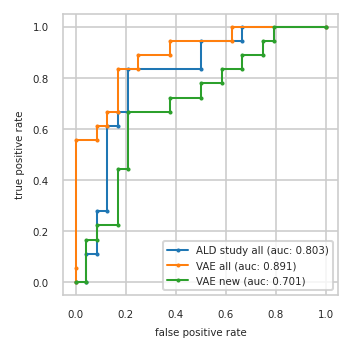

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.111   0.000 0.556   0.042 0.167
3          0.083 0.111   0.083 0.556   0.083 0.167
4          0.083 0.278   0.083 0.611   0.083 0.222
5          0.125 0.278   0.125 0.611   0.167 0.222
6          0.125 0.611   0.125 0.667   0.167 0.444
7          0.167 0.611   0.167 0.667   0.208 0.444
8          0.167 0.667   0.167 0.833   0.208 0.667
9          0.208 0.667   0.250 0.833   0.375 0.667
10         0.208 0.833   0.250 0.889   0.375 0.722
11         0.500 0.833   0.375 0.889   0.500 0.722
12         0.500 0.944   0.375 0.944   0.500 0.778
13         0.667 0.944   0.625 0.944   0.583 0.778
14         0.667 1.000   0.625 1.000   0.583 0.833
15         1.000 1.000   1.000 1.000   0.667 0.833
16           NaN   NaN     NaN   NaN   0.667 0.889
17           NaN   NaN     NaN   NaN   0.750 0.889
18           NaN   NaN     NaN   NaN   0.750 0.944
19           NaN   NaN     NaN   NaN   0.792 0.944
20           NaN   NaN     NaN   NaN   0.792 1.000
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q86SR1,K4DIA0;O75144;O75144-2,A0A087WXB8;Q9Y274
2,A6NFX8;Q9UKK9,P51688,P51688
3,P04075,Q9Y2T3;Q9Y2T3-3,P31321
4,P61981,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P05413;S4R371,P14174,J3KSJ8;Q9UD71;Q9UD71-2
7,Q99983,Q14894,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,P63104,Q9H741


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


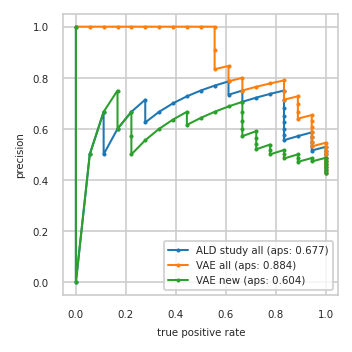

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.500 0.778
15         0.556 0.833     0.630 0.944     0.519 0.778
16         0.577 0.833     0.654 0.944     0.538 0.778
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.652 0.833     0.696 0.889     0.565 0.722
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.714 0.833     0.714 0.833     0.571 0.667
22         0.750 0.833     0.750 0.833     0.600 0.667
23         0.737 0.778     0.789 0.833     0.632 0.667
24         0.722 0.722     0.778 0.778     0.667 0.667
25         0.706 0.667     0.765 0.722     0.706 0.667
26         0.750 0.667     0.750 0.667     0.688 0.611
27         0.733 0.611     0.800 0.667     0.667 0.556
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.769 0.556     0.846 0.611     0.615 0.444
30         0.750 0.500     0.833 0.556     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     1.000 0.556     0.600 0.333
33         0.667 0.333     1.000 0.500     0.556 0.278
34         0.625 0.278     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.600 0.167     1.000 0.278     0.600 0.167
38         0.500 0.111     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


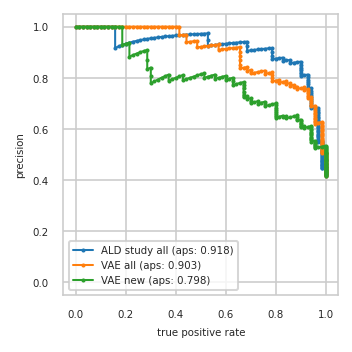

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


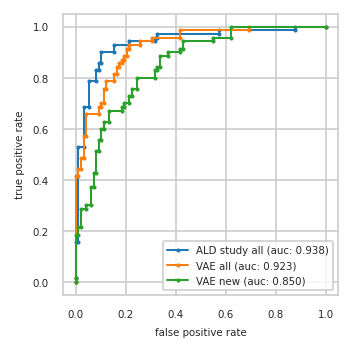

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}